<a href="https://colab.research.google.com/github/housemLassoued/ML-deployment/blob/main/Forecasting_energy_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


In [2]:
df=pd.read_csv('/content/585.csv', sep=';')

In [3]:
df

,Date,Td SC-BT-585-ARM-BAT-TGBT_2
0,31/12/2016 23:50:00,879852
1,01/01/2017 00:00:00,879852
2,01/01/2017 00:10:00,879871
3,01/01/2017 00:20:00,879881
4,01/01/2017 00:30:00,879890
...,...,...
52695,01/01/2018 23:20:00,1581261
52696,01/01/2018 23:30:00,1581270
52697,01/01/2018 23:40:00,1581278
52698,01/01/2018 23:50:00,1581286


In [4]:
# Convertir la colonne 'Date' en datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')

In [5]:
df

,Date,Td SC-BT-585-ARM-BAT-TGBT_2
0,2016-12-31 23:50:00,879852
1,2017-01-01 00:00:00,879852
2,2017-01-01 00:10:00,879871
3,2017-01-01 00:20:00,879881
4,2017-01-01 00:30:00,879890
...,...,...
52695,2018-01-01 23:20:00,1581261
52696,2018-01-01 23:30:00,1581270
52697,2018-01-01 23:40:00,1581278
52698,2018-01-01 23:50:00,1581286


In [6]:
# Définir la colonne 'Date' comme index
df.set_index('Date', inplace=True)

In [7]:
df

,Td SC-BT-585-ARM-BAT-TGBT_2
Date,
2016-12-31 23:50:00,879852
2017-01-01 00:00:00,879852
2017-01-01 00:10:00,879871
2017-01-01 00:20:00,879881
2017-01-01 00:30:00,879890
...,...
2018-01-01 23:20:00,1581261
2018-01-01 23:30:00,1581270
2018-01-01 23:40:00,1581278


In [8]:
# Initialiser le scaler
scaler = MinMaxScaler()
# Normaliser la colonne d'énergie
df['Td SC-BT-585-ARM-BAT-TGBT_2'] = scaler.fit_transform(df[['Td SC-BT-585-ARM-BAT-TGBT_2']])


In [9]:
df

,Td SC-BT-585-ARM-BAT-TGBT_2
Date,
2016-12-31 23:50:00,0.000000
2017-01-01 00:00:00,0.000000
2017-01-01 00:10:00,0.000027
2017-01-01 00:20:00,0.000041
2017-01-01 00:30:00,0.000054
...,...
2018-01-01 23:20:00,0.999952
2018-01-01 23:30:00,0.999964
2018-01-01 23:40:00,0.999976


In [10]:
# Définir la taille de la fenêtre (par exemple 60 pour une heure de données)
window_size = 60

# Créer les séquences d'entrée et les étiquettes de sortie
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(df['Td SC-BT-585-ARM-BAT-TGBT_2'].values, window_size)


In [11]:
print(X.shape, y.shape)

(52640, 60) (52640,)


In [12]:
# Diviser les données en ensembles d'entraînement et de test
split_ratio = 0.8
train_size = int(len(X) * split_ratio)

In [13]:
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [14]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, output_dim):
        super(TimeSeriesTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        out = self.transformer_encoder(src)
        out = self.fc(out[-1])
        return out


In [15]:
# Définir les dimensions et les paramètres
input_dim = 60
num_heads = 2
num_layers = 2
hidden_dim = 64
output_dim = 1

# Instancier le modèle
model = TimeSeriesTransformer(input_dim, num_heads, num_layers, hidden_dim, output_dim)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
# Convertir les données en tenseurs
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [17]:
# Créer un DataLoader
batch_size = 64
dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_test = TensorDataset(X_test_tensor, y_test_tensor)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)




In [18]:
# Définir une fonction de perte et un optimiseur
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [19]:
# Boucle d'entraînement
num_epochs = 50
for epoch in range(num_epochs):
    for X_batch, y_batch in dataloader_train:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Loss: 0.0594172440469265
Epoch 2/50, Loss: 0.04125995561480522
Epoch 3/50, Loss: 0.06490174680948257
Epoch 4/50, Loss: 0.04699402302503586
Epoch 5/50, Loss: 0.063811756670475
Epoch 6/50, Loss: 0.06875862181186676
Epoch 7/50, Loss: 0.07316108047962189
Epoch 8/50, Loss: 0.05863891541957855
Epoch 9/50, Loss: 0.0639224648475647
Epoch 10/50, Loss: 0.0638541653752327
Epoch 11/50, Loss: 0.05399658903479576
Epoch 12/50, Loss: 0.04654436558485031
Epoch 13/50, Loss: 0.055227309465408325
Epoch 14/50, Loss: 0.0614306777715683
Epoch 15/50, Loss: 0.05834360420703888
Epoch 16/50, Loss: 0.06053788959980011
Epoch 17/50, Loss: 0.06284914165735245
Epoch 18/50, Loss: 0.060688477009534836
Epoch 19/50, Loss: 0.060276515781879425
Epoch 20/50, Loss: 0.05728785693645477
Epoch 21/50, Loss: 0.060787737369537354
Epoch 22/50, Loss: 0.06034693121910095
Epoch 23/50, Loss: 0.06209009885787964
Epoch 24/50, Loss: 0.06047957390546799
Epoch 25/50, Loss: 0.06435905396938324
Epoch 26/50, Loss: 0.060863666236400

In [20]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss: {loss.item()}')

Test Loss: 0.2617233991622925


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([10528])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


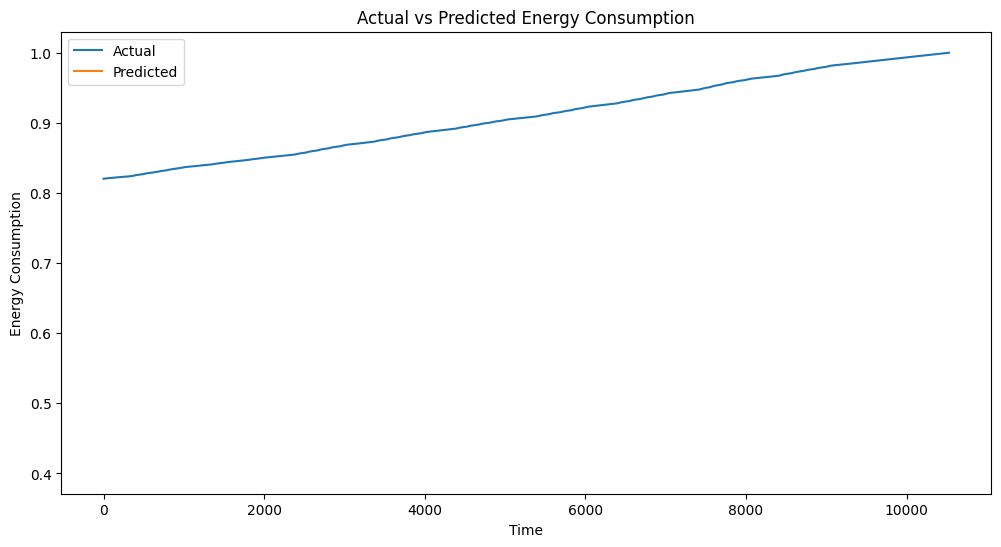

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_tensor, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()
